In [1]:
# Import functions and libraries

import numpy as np
import matplotlib.pyplot as plt
import pyaudio, threading,time, sys, threading,time, serial
import queue as Queue
from numpy import pi, sin, zeros, r_
from scipy import signal
from scipy import misc
from scipy import ndimage
import copy
# from rtlsdr import RtlSdr
import sounddevice as sd
# import RPi.GPIO as GPIO
import pywt
%matplotlib inline
import bitarray, time, urllib, ssl
from scipy import signal, integrate
from math import gcd
from functools import reduce
from numpy.random import rand, randn
from numpy import ones,zeros, pi, cos, exp, sign
import copy

In [2]:
# function to compute average power spectrum
def avgPS( x, N=256, fs=1):
    M = (len(x)//N)
    x_ = np.reshape(x[:M*N],(M,N)) * np.hamming(N)[None,:]
    X = np.fft.fftshift(np.fft.fft(x_,axis=1),axes=1)
    return r_[-N/2.0:N/2.0]/N*fs, np.mean(abs(X)**2,axis=0)


# Plot an image of the spectrogram y, with the axis labeled with time tl,
# and frequency fl
#
# t_range -- time axis label, nt samples
# f_range -- frequency axis label, nf samples
# y -- spectrogram, nf by nt array
# dbf -- Dynamic range of the spect

def sg_plot( t_range, f_range, y, dbf = 60, fig = None) :
    eps = 10.0**(-dbf/20.0)  # minimum signal
    
    # find maximum
    y_max = abs(y).max()
    
    # compute 20*log magnitude, scaled to the max
    y_log = 20.0 * np.log10( (abs( y ) / y_max)*(1-eps) + eps )
    
    # rescale image intensity to 256
    img = 256*(y_log + dbf)/dbf - 1
    
    fig=plt.figure(figsize=(16,6))
    
    plt.imshow( np.flipud( 64.0*(y_log + dbf)/dbf ), extent= t_range  + f_range ,cmap=plt.cm.gray, aspect='auto')
    plt.xlabel('Time, s')
    plt.ylabel('Frequency, Hz')
    plt.tight_layout()
    plt.show()
    return fig


def myspectrogram_hann_ovlp(x, m, fs, fc,dbf = 60):
    # Plot the spectrogram of x.
    # First take the original signal x and split it into blocks of length m
    # This corresponds to using a rectangular window %
    
    
    isreal_bool = np.isreal(x).all()
    
    # pad x up to a multiple of m 
    lx = len(x);
    nt = (lx + m - 1) // m
    x = np.append(x,zeros(-lx+nt*m))
    x = x.reshape((m//2,nt*2), order='F')
    x = np.concatenate((x,x),axis=0)
    x = x.reshape((m*nt*2,1),order='F')
    x = x[r_[m//2:len(x),np.ones(m//2)*(len(x)-1)].astype(int)].reshape((m,nt*2),order='F')
    
    
    xmw = x * np.hanning(m)[:,None];
    
    
    # frequency index
    t_range = [0.0, lx / fs]
    
    if isreal_bool:
        f_range = [ fc, fs / 2.0 + fc]
        xmf = np.fft.fft(xmw,len(xmw),axis=0)
        sg_plot(t_range, f_range, xmf[0:m//2,:],dbf=dbf)
    else:
        f_range = [-fs / 2.0 + fc, fs / 2.0 + fc]
        xmf = np.fft.fftshift( np.fft.fft( xmw ,len(xmw),axis=0), axes=0 )
        sg_plot(t_range, f_range, xmf,dbf = dbf)
    
    return t_range, f_range, xmf

In [3]:
GPIO.setmode(GPIO.BOARD)

NameError: name 'GPIO' is not defined

In [ ]:
PTT = 12
GPIO.setup(PTT, GPIO.OUT, initial = GPIO.HIGH)

In [4]:
fs = 240000
fc =  443630000
sdr = RtlSdr()
sdr.sample_rate = fs    # sampling rate
sdr.gain = gaincalib
sdr.center_freq = fc
sdr.set_freq_correction(int(ppmcalib))


YOURCALLSIGN="KM6QGJ"
audio_gain = 1


callsign = text2Morse(YOURCALLSIGN,850,48000,75e-3)*audio_gain
callsign = np.concatenate((np.zeros(4800),callsign))                      



GPIO.output(PTT, GPIO.LOW)
sd.play(callsign,samplerate=48000,device=5,  blocking=False)
y = sdr.read_samples(256000*7)
sdr.close()
GPIO.output(PTT, GPIO.HIGH)

NameError: name 'RtlSdr' is not defined

In [103]:
im = misc.imread('images/calBlue.tiff')
# print(im)
dims = im.shape[0:2]
def flattenImage(img): 
    r = img[:,:,0].flatten()
    g = img[:,:,1].flatten()
    b = img[:,:,2].flatten()
    bits = np.hstack((r,g,b))
    return r,g,b,bits
r,g,b,bits = flattenImage(im)
# print(r)

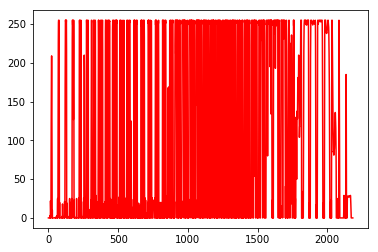

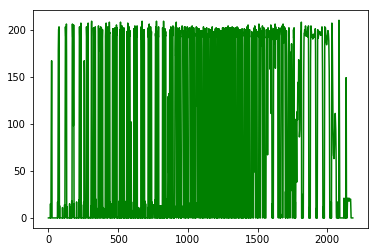

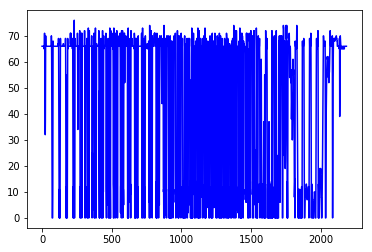

In [104]:
plt.plot(r, color='red')
plt.show()
plt.plot(g, color='green')
plt.show()
plt.plot(b, color = 'blue')
plt.show()

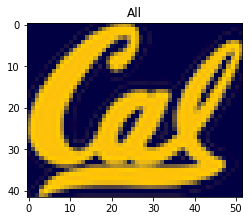

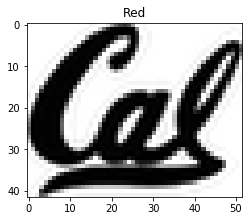

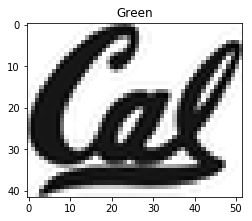

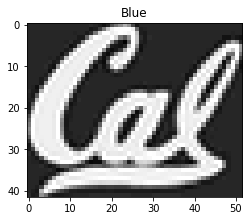

In [105]:
width, height = plt.figaspect(.2)
plt.figure(figsize = (width, height))
plt.title('All')
plt.imshow(im, cmap="Greys")
plt.show()

width, height = plt.figaspect(.2)
plt.figure(figsize = (width, height))
plt.title('Red')
plt.imshow(r.reshape(dims), cmap="Greys")
plt.show()

width, height = plt.figaspect(.2)
plt.figure(figsize = (width, height))
plt.title('Green')
plt.imshow(g.reshape(dims), cmap="Greys")
plt.show()

width, height = plt.figaspect(.2)
plt.figure(figsize = (width, height))
plt.title('Blue')
plt.imshow(b.reshape(dims), cmap="Greys")
plt.show()

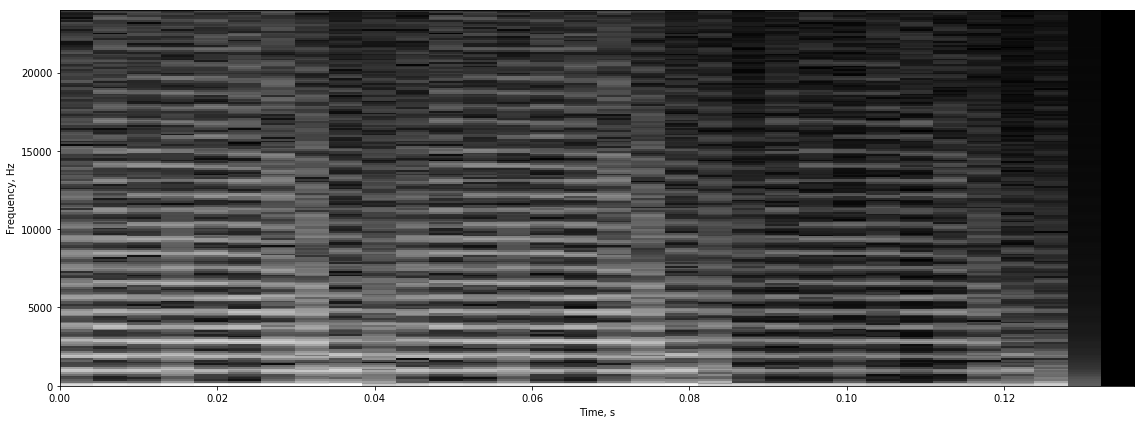

In [106]:
tt, ff, xmf = myspectrogram_hann_ovlp(bits[:], 432, 48000, 0)

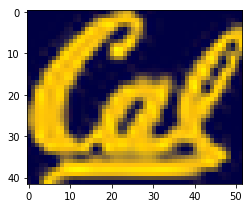

In [107]:
def downsample_image(im, L):
    dIm = im[::L, ::L, :]
#     print(im, dIm)
#     print(len(im), len(dIm))
    r,g,b,bits = flattenImage(dIm)
#     print(r,g,b)
    return r,g,b,bits

def recover_image(bits, dims, M):
    r, g, b = bits[:len(bits)//3], bits[len(bits)//3:2*len(bits)//3], bits[2*len(bits)//3:]
#     print(len(r), dims)
    rgb_bits = np.column_stack((r,g,b))[None,:,:]
    rgb_bits = rgb_bits.reshape(tuple([dim//M for dim in dims]+[3]))
#     print(rgb_bits)
    return ndimage.zoom(rgb_bits, (M,M,1))

_,_,_,bits = downsample_image(im, 2)
dims = im.shape[:2]
duIm = recover_image(bits, dims, 2)
width, height = plt.figaspect(.2)
plt.figure(figsize = (width, height))
plt.imshow(duIm)
plt.show()

In [108]:
def psnr(im1, im2):
    MSE = 0
    dims = im.shape
    for i in range(dims[0]):
        for j in range(dims[1]):
            for c in range(dims[2]):
                MSE += pow(im1[i][j][c]-im2[i][j][c], 2)/np.prod(dims)
#                 print(im1[i][j][c],im2[i][j][c])
#     MSE *= 1/np.prod(dims)
    return 10*np.log10(255*255/MSE)

In [109]:
psnr(im, duIm)

C:\Users\liget_4sn\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in ubyte_scalars
  import sys


4.4591616884516441

In [110]:
def im2Channels(im):
    return im[:,:,0], im[:,:,1], im[:,:,2]
def channels2Im(ch1,ch2,ch3):
    return np.dstack((ch1,ch2,ch3))

In [157]:
def rgb2ycbcr(im):
    def transform(rgb):
        A = np.array([[.299, .587, .114],
                 [-.168736, -.331264, .5],
                 [.5, -.418688,-.081312]])
        c = np.array([0,128,128])
        ycbcr = np.dot(A, rgb)
        ycbcr += c
        return ycbcr
    ycbcr_im = np.apply_along_axis(transform, 2, im)
    return ycbcr_im
def ycbcr2rgb(im):
    def transform(ycbcr):
        A = np.array([[1, 0, 1.402],
                     [1, -.344136, -.714136],
                     [1, 1.772, 0]])
        c = np.array([0,128,128])
        print('=================')
        print(ycbcr)
        rgb = ycbcr - c
        print(rgb)
        rgb = np.dot(A, rgb)
        print(A, rgb)
        return np.round(rgb)
    rgb_im = np.apply_along_axis(transform, 2, im)
    return rgb_im

[[[ 0  0 66]
  [ 0  0 66]
  [ 0  0 66]
  ..., 
  [ 0  0 66]
  [ 0  0 66]
  [ 1  0 66]]

 [[ 0  0 66]
  [ 0  0 66]
  [ 0  0 66]
  ..., 
  [18 11 66]
  [13  6 66]
  [ 0  0 66]]

 [[ 0  0 66]
  [ 0  0 66]
  [ 0  0 66]
  ..., 
  [ 0  0 67]
  [ 0  0 66]
  [20 12 66]]

 ..., 
 [[ 0  0 66]
  [23 17 66]
  [ 0  0 68]
  ..., 
  [ 0  0 66]
  [ 0  0 66]
  [ 0  0 66]]

 [[16 10 66]
  [ 0  0 68]
  [ 0  0 70]
  ..., 
  [ 0  0 66]
  [ 0  0 66]
  [ 0  0 66]]

 [[19 13 65]
  [ 0  0 69]
  [41 37 68]
  ..., 
  [ 0  0 66]
  [ 0  0 66]
  [ 0  0 66]]]


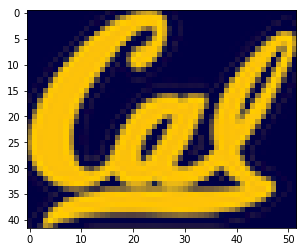

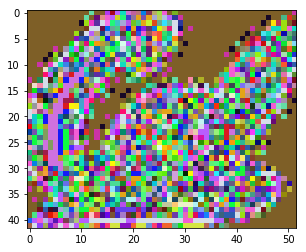

[   7.524     161.        122.633408]
[  7.524     33.        -5.366592]
[[ 1.        0.        1.402   ]
 [ 1.       -0.344136 -0.714136]
 [ 1.        1.772     0.      ]] [  3.80160000e-05  -1.14554880e-05   6.60000000e+01]
[   7.524     161.        122.633408]
[  7.524     33.        -5.366592]
[[ 1.        0.        1.402   ]
 [ 1.       -0.344136 -0.714136]
 [ 1.        1.772     0.      ]] [  3.80160000e-05  -1.14554880e-05   6.60000000e+01]
[   7.524     161.        122.633408]
[  7.524     33.        -5.366592]
[[ 1.        0.        1.402   ]
 [ 1.       -0.344136 -0.714136]
 [ 1.        1.772     0.      ]] [  3.80160000e-05  -1.14554880e-05   6.60000000e+01]
[   7.524     161.        122.633408]
[  7.524     33.        -5.366592]
[[ 1.        0.        1.402   ]
 [ 1.       -0.344136 -0.714136]
 [ 1.        1.772     0.      ]] [  3.80160000e-05  -1.14554880e-05   6.60000000e+01]
[   7.524     161.        122.633408]
[  7.524     33.        -5.366592]
[[ 1.        0.        

[   7.524     161.        122.633408]
[  7.524     33.        -5.366592]
[[ 1.        0.        1.402   ]
 [ 1.       -0.344136 -0.714136]
 [ 1.        1.772     0.      ]] [  3.80160000e-05  -1.14554880e-05   6.60000000e+01]
[   7.524     161.        122.633408]
[  7.524     33.        -5.366592]
[[ 1.        0.        1.402   ]
 [ 1.       -0.344136 -0.714136]
 [ 1.        1.772     0.      ]] [  3.80160000e-05  -1.14554880e-05   6.60000000e+01]
[   7.524     161.        122.633408]
[  7.524     33.        -5.366592]
[[ 1.        0.        1.402   ]
 [ 1.       -0.344136 -0.714136]
 [ 1.        1.772     0.      ]] [  3.80160000e-05  -1.14554880e-05   6.60000000e+01]
[   8.122     160.662528  123.633408]
[  8.122     32.662528  -4.366592]
[[ 1.        0.        1.402   ]
 [ 1.       -0.344136 -0.714136]
 [ 1.        1.772     0.      ]] [  2.00003802e+00  -1.11912960e-05   6.59999996e+01]
[   7.524     161.        122.633408]
[  7.524     33.        -5.366592]
[[ 1.        0.        

[   7.524     161.        122.633408]
[  7.524     33.        -5.366592]
[[ 1.        0.        1.402   ]
 [ 1.       -0.344136 -0.714136]
 [ 1.        1.772     0.      ]] [  3.80160000e-05  -1.14554880e-05   6.60000000e+01]
[   7.524     161.        122.633408]
[  7.524     33.        -5.366592]
[[ 1.        0.        1.402   ]
 [ 1.       -0.344136 -0.714136]
 [ 1.        1.772     0.      ]] [  3.80160000e-05  -1.14554880e-05   6.60000000e+01]
[   8.122     160.662528  123.633408]
[  8.122     32.662528  -4.366592]
[[ 1.        0.        1.402   ]
 [ 1.       -0.344136 -0.714136]
 [ 1.        1.772     0.      ]] [  2.00003802e+00  -1.11912960e-05   6.59999996e+01]
[   7.524     161.        122.633408]
[  7.524     33.        -5.366592]
[[ 1.        0.        1.402   ]
 [ 1.       -0.344136 -0.714136]
 [ 1.        1.772     0.      ]] [  3.80160000e-05  -1.14554880e-05   6.60000000e+01]
[  11.688     158.650112  126.796032]
[ 11.688     30.650112  -1.203968]
[[ 1.        0.        

 [ 1.        1.772     0.      ]] [  3.80160000e-05  -1.14554880e-05   6.60000000e+01]
[   7.524     161.        122.633408]
[  7.524     33.        -5.366592]
[[ 1.        0.        1.402   ]
 [ 1.       -0.344136 -0.714136]
 [ 1.        1.772     0.      ]] [  3.80160000e-05  -1.14554880e-05   6.60000000e+01]
[   7.524     161.        122.633408]
[  7.524     33.        -5.366592]
[[ 1.        0.        1.402   ]
 [ 1.       -0.344136 -0.714136]
 [ 1.        1.772     0.      ]] [  3.80160000e-05  -1.14554880e-05   6.60000000e+01]
[   7.524     161.        122.633408]
[  7.524     33.        -5.366592]
[[ 1.        0.        1.402   ]
 [ 1.       -0.344136 -0.714136]
 [ 1.        1.772     0.      ]] [  3.80160000e-05  -1.14554880e-05   6.60000000e+01]
[   7.524     161.        122.633408]
[  7.524     33.        -5.366592]
[[ 1.        0.        1.402   ]
 [ 1.       -0.344136 -0.714136]
 [ 1.        1.772     0.      ]] [  3.80160000e-05  -1.14554880e-05   6.60000000e+01]
[  26.049

 [ 1.        1.772     0.      ]] [  3.80160000e-05  -1.14554880e-05   6.60000000e+01]
[  26.451     150.318848  127.678336]
[ 26.451     22.318848  -0.321664]
[[ 1.        0.        1.402   ]
 [ 1.       -0.344136 -0.714136]
 [ 1.        1.772     0.      ]] [ 26.00002707  18.99999277  65.99999866]
[   7.752     162.        122.470784]
[  7.752     34.        -5.529216]
[[ 1.        0.        1.402   ]
 [ 1.       -0.344136 -0.714136]
 [ 1.        1.772     0.      ]] [  3.91680000e-05  -1.18026240e-05   6.80000000e+01]
[  82.162     113.800224  137.870176]
[ 82.162    -14.199776   9.870176]
[[ 1.        0.        1.402   ]
 [ 1.       -0.344136 -0.714136]
 [ 1.        1.772     0.      ]] [ 95.99998675  80.00000611  56.99999693]
[ 186.957      30.394464  167.973536]
[ 186.957     -97.605536   39.973536]
[[ 1.        0.        1.402   ]
 [ 1.       -0.344136 -0.714136]
 [ 1.        1.772     0.      ]] [ 242.99989747  192.00003763   13.99999021]
[ 191.981      23.044576  172.94928 ]
[

[   7.524     161.        122.633408]
[  7.524     33.        -5.366592]
[[ 1.        0.        1.402   ]
 [ 1.       -0.344136 -0.714136]
 [ 1.        1.772     0.      ]] [  3.80160000e-05  -1.14554880e-05   6.60000000e+01]
[   7.524     161.        122.633408]
[  7.524     33.        -5.366592]
[[ 1.        0.        1.402   ]
 [ 1.       -0.344136 -0.714136]
 [ 1.        1.772     0.      ]] [  3.80160000e-05  -1.14554880e-05   6.60000000e+01]
[   7.866     162.5       122.389472]
[  7.866     34.5       -5.610528]
[[ 1.        0.        1.402   ]
 [ 1.       -0.344136 -0.714136]
 [ 1.        1.772     0.      ]] [  3.97440000e-05  -1.19761920e-05   6.90000000e+01]
[  97.306     104.12528   141.333792]
[ 97.306    -23.87472   13.333792]
[[ 1.        0.        1.402   ]
 [ 1.       -0.344136 -0.714136]
 [ 1.        1.772     0.      ]] [ 115.99997638   96.00000976   54.99999616]
[ 190.361      23.394464  169.111904]
[ 190.361    -104.605536   41.111904]
[[ 1.        0.        1.402 

[ 189.007      27.544576  172.217472]
[ 189.007    -100.455424   44.217472]
[[ 1.        0.        1.402   ]
 [ 1.       -0.344136 -0.714136]
 [ 1.        1.772     0.      ]] [ 250.99989574  192.00003921   10.99998867]
[ 190.252      25.713312  172.04272 ]
[ 190.252    -102.286688   44.04272 ]
[[ 1.        0.        1.402   ]
 [ 1.       -0.344136 -0.714136]
 [ 1.        1.772     0.      ]] [ 251.99989344  194.00003977    8.99998886]
[ 190.551      25.544576  172.54272 ]
[ 190.551    -102.455424   44.54272 ]
[[ 1.        0.        1.402   ]
 [ 1.       -0.344136 -0.714136]
 [ 1.        1.772     0.      ]] [ 252.99989344  194.0000399     8.99998867]
[ 190.551      25.544576  172.54272 ]
[ 190.551    -102.455424   44.54272 ]
[[ 1.        0.        1.402   ]
 [ 1.       -0.344136 -0.714136]
 [ 1.        1.772     0.      ]] [ 252.99989344  194.0000399     8.99998867]
[ 188.822      28.213312  171.63616 ]
[ 188.822     -99.786688   43.63616 ]
[[ 1.        0.        1.402   ]
 [ 1.      

 [ 1.        1.772     0.      ]] [  2.54999885e+02   2.00000042e+02  -1.05600000e-05]
[ 191.366      26.213312  171.961408]
[ 191.366    -101.786688   43.961408]
[[ 1.        0.        1.402   ]
 [ 1.       -0.344136 -0.714136]
 [ 1.        1.772     0.      ]] [ 252.99989402  195.0000396    10.99998886]
[ 191.654      26.050784  171.04272 ]
[ 191.654    -101.949216   43.04272 ]
[[ 1.        0.        1.402   ]
 [ 1.       -0.344136 -0.714136]
 [ 1.        1.772     0.      ]] [ 251.99989344  196.00003951   10.99998925]
[ 189.594      27.213312  171.798784]
[ 189.594    -100.786688   43.798784]
[[ 1.        0.        1.402   ]
 [ 1.       -0.344136 -0.714136]
 [ 1.        1.772     0.      ]] [ 250.99989517  193.00003925   10.99998886]
[ 191.437      25.044576  172.624032]
[ 191.437    -102.955424   44.624032]
[[ 1.        0.        1.402   ]
 [ 1.       -0.344136 -0.714136]
 [ 1.        1.772     0.      ]] [ 253.99989286  195.00004008    8.99998867]
[ 192.6        24.388256  170.367

[ 193.058      19.050784  172.181088]
[ 193.058    -108.949216   44.181088]
[[ 1.        0.        1.402   ]
 [ 1.       -0.344136 -0.714136]
 [ 1.        1.772     0.      ]] [  2.54999885e+02   1.99000042e+02  -1.07520000e-05]
[ 194.819      18.056992  170.925024]
[ 194.819    -109.943008   42.925024]
[[ 1.        0.        1.402   ]
 [ 1.       -0.344136 -0.714136]
 [ 1.        1.772     0.      ]] [  2.54999884e+02   2.02000042e+02  -1.01760000e-05]
[ 194.52       18.225728  170.425024]
[ 194.52     -109.774272   42.425024]
[[ 1.        0.        1.402   ]
 [ 1.       -0.344136 -0.714136]
 [ 1.        1.772     0.      ]] [  2.53999884e+02   2.02000042e+02  -9.98400000e-06]
[ 173.583      46.40688   162.534176]
[ 173.583     -81.59312    34.534176]
[[ 1.        0.        1.402   ]
 [ 1.       -0.344136 -0.714136]
 [ 1.        1.772     0.      ]] [ 221.99991475  177.00003163   28.99999136]
[ 107.547      97.7816    144.728224]
[ 107.547     -30.2184     16.728224]
[[ 1.        0.  

 [ 1.        1.772     0.      ]] [  3.97440000e-05  -1.19761920e-05   6.90000000e+01]
[   7.638     161.5       122.552096]
[  7.638     33.5       -5.447904]
[[ 1.        0.        1.402   ]
 [ 1.       -0.344136 -0.714136]
 [ 1.        1.772     0.      ]] [  3.85920000e-05  -1.16290560e-05   6.70000000e+01]
[  20.135     153.318848  127.190464]
[ 20.135     25.318848  -0.809536]
[[ 1.        0.        1.402   ]
 [ 1.       -0.344136 -0.714136]
 [ 1.        1.772     0.      ]] [ 19.00003053  11.99999173  64.99999866]
[   7.524     161.        122.633408]
[  7.524     33.        -5.366592]
[[ 1.        0.        1.402   ]
 [ 1.       -0.344136 -0.714136]
 [ 1.        1.772     0.      ]] [  3.80160000e-05  -1.14554880e-05   6.60000000e+01]
[   7.524     161.        122.633408]
[  7.524     33.        -5.366592]
[[ 1.        0.        1.402   ]
 [ 1.       -0.344136 -0.714136]
 [ 1.        1.772     0.      ]] [  3.80160000e-05  -1.14554880e-05   6.60000000e+01]
[   7.524     161.   

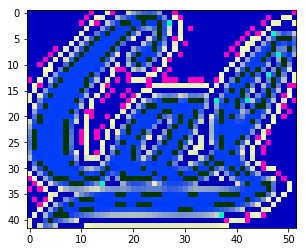

In [161]:
# print(rgb2ycbcr(im))
im = [[] for i in ]
print(im)
plt.imshow(im)
plt.show()
y_im = rgb2ycbcr(im)
plt.imshow(y_im)
plt.show()
rgb_im = ycbcr2rgb(y_im)
plt.imshow(rgb_im)
plt.show()

In [147]:
 def r2ytransform(rgb):
        A = np.array([[.299, .587, .114],
                 [-.168736, -.331264, .5],
                 [.5, -.418688,-.081312]])
        c = np.array([0,128,128])
        ycbcr = np.dot(A, rgb)
        ycbcr += c
        return ycbcr
def y2rtransform(ycbcr):
        A = np.array([[1, 0, 1.402],
                     [1, -.344136, -.714136],
                     [1, 1.772, 0]])
        c = np.array([0,128,128])
        rgb = ycbcr - c
        rgb = np.dot(A, rgb)
        return np.round(rgb)

In [160]:
print(r2ytransform([0,0,66]))
print(y2rtransform([7.524,161.,        122.633408]))

[   7.524     161.        122.633408]
[  0.  -0.  66.]


In [ ]:
#color transform
ycbcr_im =im2Channels(rgb2ycbcr(im))

In [ ]:

N = 8
# for i in range(len(r)//N):
#     for j in range(im.shape[1]//N):
#         r_sec = r[i*N:i*N+N,j*N:j*N+N]-128
#         plt.imshow(r_sec, cmap='Greys')
#         plt.show()
#         r_wvlt = pywt.dwt2(r_sec, 'db9')
#         print(r_wvlt)
#         f, axarr = plt.subplots(2,2, sharex=True, sharey=True)
#         axarr[0,0].imshow(r_wvlt[0])
#         axarr[0,1].imshow(r_wvlt[1][0])
#         axarr[1,0].imshow(r_wvlt[1][1])
#         axarr[1,1].imshow(r_wvlt[1][2])
#         plt.imshow(r_wvlt[1][0], cmap='Greys')
#         plt.plot(r_wvlt[1][0].flatten())
#         plt.imshow(r_wvlt[1][0], cmap = "Greys")
#         plt.imshow(r_wvlt[1][0])
#         plt.imshow(r_wvlt[1][1])
#         plt.imshow(r_wvlt[1][2])
#         plt.show()

In [ ]:
#db9 wavelet transform
ycbcr_w = []
wavelet = 'db9'
max_level = 2
for ch in ycbcr_im:
    chw = pywt.wavedec2(ch-128, wavelet, level=max_level)
    ycbcr_w.append(chw)
#     print(chw)

In [73]:
def plot_wavelets(imw):
    for chw in imw:
        for i in range(len(chw)):
            if i == 0:
                plt.title('Approximation')
                plt.imshow(chw[0], cmap='Greys')
                plt.show()
            else:
                for j in range(len(chw[i])):
                    plt.title('Wavelet level = ' + str(i) + ', component ' + str(j))
                    plt.imshow(chw[i][j], cmap='Greys')
                    plt.show()

[array([[ 507.98548238,  508.00230088,  507.99965145, ...,  508.00000675,
         507.99993621,  508.00033959],
       [ 507.98304131,  508.00220567,  507.99979128, ...,  507.99999665,
         508.00002223,  507.99990642],
       [ 508.00178997,  507.99978597,  508.00002145, ...,  508.00000037,
         507.99999833,  508.00000458],
       ..., 
       [ 508.        ,  508.        ,  508.        , ...,  508.        ,
         508.        ,  508.        ],
       [ 508.        ,  508.        ,  508.        , ...,  508.        ,
         508.        ,  508.        ],
       [ 508.        ,  508.        ,  508.        , ...,  508.        ,
         508.        ,  508.        ]]), (array([[ -6.59843258e-03,   6.13858992e-04,  -2.01674490e-04, ...,
          5.95731096e-08,  -3.77537769e-07,   1.54312967e-06],
       [  6.69258701e-03,  -5.23953591e-04,   2.58127416e-04, ...,
         -7.28396072e-09,   4.03162039e-08,  -1.44182831e-07],
       [ -1.82718178e-02,   2.17307353e-03,  -2.053

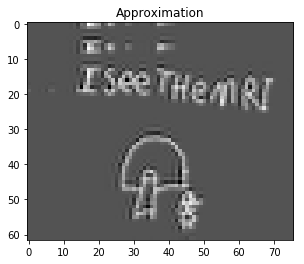

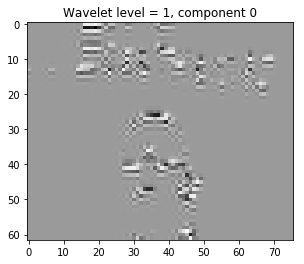

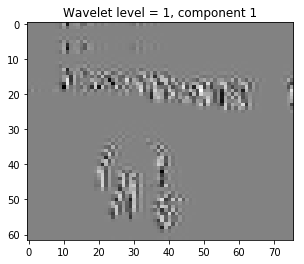

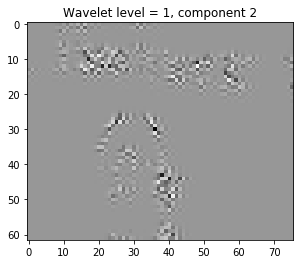

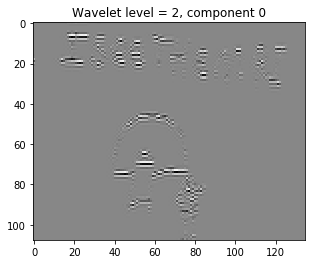

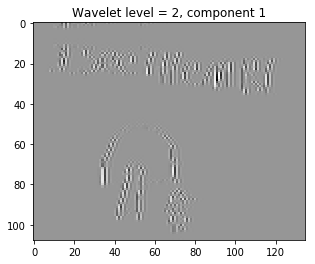

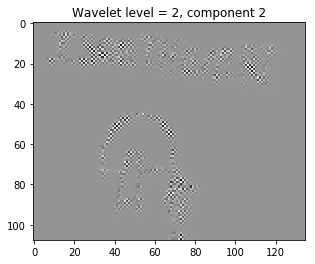

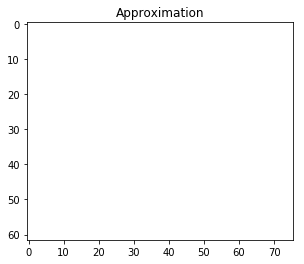

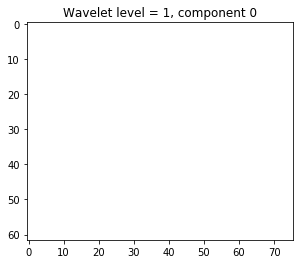

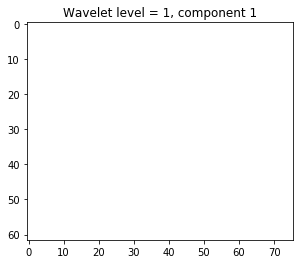

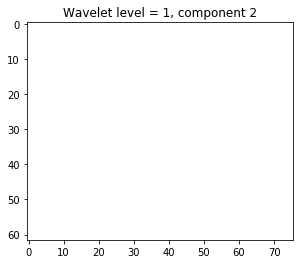

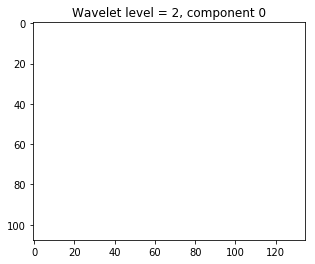

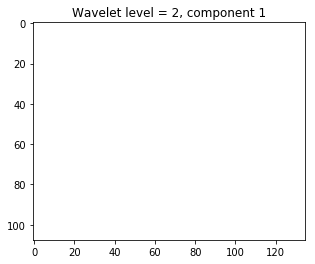

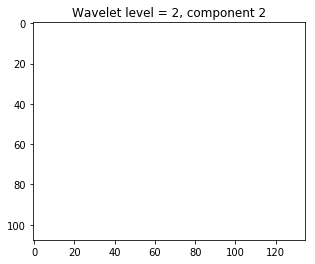

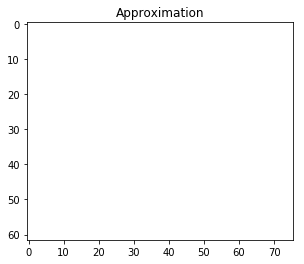

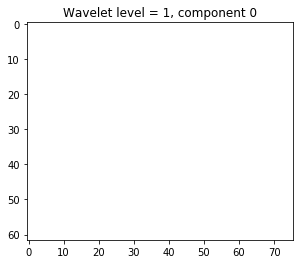

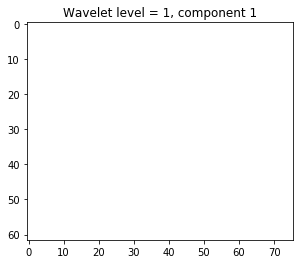

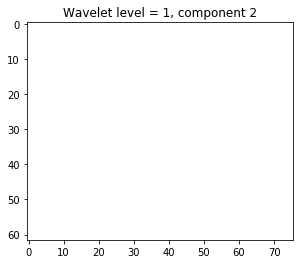

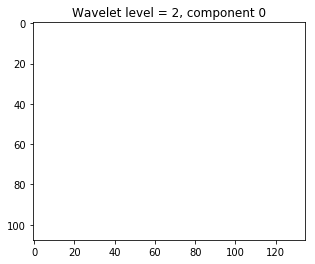

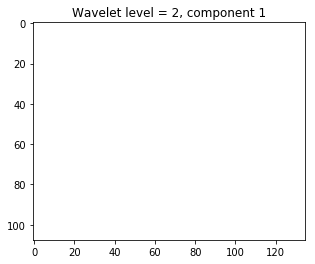

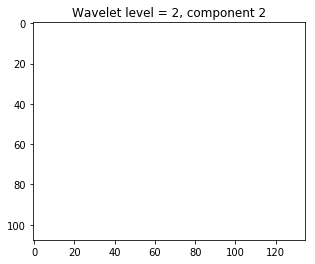

In [72]:
#threshold wavelet coeffs
thresh = 25
for channel in ycbcr_w:
    for level in channel:
        for arr in level:
            arr = np.where(arr<thresh, 0, arr)
plot_wavelets(ycbcr_w)

#quantize